# Datos del codigo:
* Estudiante: Juan Jose Valverde Campos
* Carnet: B47200
* Laboratorio 4 - CNN
* Profesor: Pablo Sauma Chacón

# 1. Importación de Librerías

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch as pt 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

# 2. Se obtienen los datos con los cuales se va a trabajar

In [12]:
# Custom subdirectory to find images
DIRECTORY = "images"
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8') for n in unpickle(DIRECTORY+"/batches.meta")[b'label_names']]
    x_train = None
    y_train = []
    for i in range(1,6):
        data = unpickle(DIRECTORY+"/data_batch_"+str(i))
        if i>1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']
    data = unpickle(DIRECTORY+"/test_batch")
    x_test = data[b'data']
    y_test = data[b'labels']
    return names,x_train,y_train,x_test,y_test

names,x_train,y_train,x_test,y_test = load_data()
# pt.manual_seed(29)
# pt.cuda.manual_seed(29)

# 3.Se obtiene la visualización de imágenes

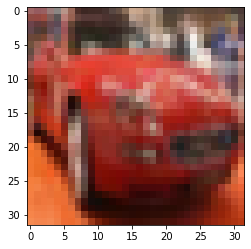

automobile


In [13]:
def plot_tensor(tensor, perm=None):
    if perm==None: perm = (1,2,0)
    plt.figure()
    plt.imshow(tensor.permute(perm).numpy().astype(np.uint8))
    plt.show()
images = pt.Tensor(x_train)
images = images.resize_(50000,3,32,32)
plot_tensor(images[5])
print(names[y_train[5]])


# 4.Se crea la clase que va a ser llamada para entrenarse

In [14]:
# Se crea una clase que hereda de torch.nn.Module
# En el constructor se debe llamar al constructor padre  y crear sus capas
# Y se debe crear su método forward que ejecuta el paso de los datos por las neuronas


class SurvivorClassifier(pt.nn.Module):
	def __init__(self):
		'''
		Se crea la red neuronal
		'''
		super().__init__()
		# 3 x 32 x 32 
		self.fc1 = pt.nn.Conv2d(3, 6, (3,3),padding= "same")
		self.act1 = pt.nn.LeakyReLU()
		self.pool1 = pt.nn.MaxPool2d(2)
		# 5 x 16 x 16 
		self.fc2 = pt.nn.Conv2d(6, 9, (5,5),padding= "same")
		self.act2 = pt.nn.LeakyReLU()
		self.pool2 = pt.nn.MaxPool2d(2)
		# 7 x 8 x 8
		self.fc3 = pt.nn.Conv2d(9, 12, (5,5),padding= "same")
		self.act3 = pt.nn.LeakyReLU()
		self.pool3 = pt.nn.AvgPool2d(2)
		# 8 x 4 x 4
		# self.fc4 = pt.nn.Conv2d(120, 5, (5,5),padding= "same")
		# self.act4 = pt.nn.LeakyReLU()
		# self.pool4 = pt.nn.AvgPool2d(2)

		# self.fc4 = pt.nn.Linear( 10 * 4 * 4, 10*4)
		self.fc4 = pt.nn.Linear( 12 * 4 * 4, 10)
		self.act4 = pt.nn.Sigmoid()

		# self.fc5 = pt.nn.Linear(10*4, 10)
		# self.act5 = pt.nn.Sigmoid()

		# # # 5 x 2 x 2 , no recomendado 
		# # self.fc5 = pt.nn.Linear(20, 10)
		# # self.act5 = pt.nn.Sigmoid()

		# self.dropout = pt.nn.Dropout(0.15)


	# 
	# Lrelu mata
	# Relu, lo mata el 0 


	# Maxpool ignora la parte de la imagen y más rapido backpropagation

	# Aumentar la dimensiones y nunca botarlo, queremos ir subiendo y subiendo


	def forward(self, x):
		h1 = self.pool1(self.act1(self.fc1(x)))
		h2 = self.pool2(self.act2(self.fc2(h1)))
		h3 = self.pool3(self.act3(self.fc3(h2)))
		# h4 = self.act4(self.fc4(h3.view(h3.size(0), -1) ))
		return self.act4(self.fc4(h3.view(h3.size(0), -1) ))
		#h4 = self.dropout(h4) # En capas densas por lo general , se podría en convolucionales pero es un punto negro
		#return self.act5( self.fc5(h4) )


# 5. Se convierte los datos en tensores y se hace los batch de entrenamiento

In [15]:
x_train = pt.Tensor(x_train)
y_train = pt.Tensor(y_train)
x_test = pt.Tensor(x_test)
y_test = pt.Tensor(y_test)
x_train = x_train.resize_(50000,3,32,32)
x_test = x_test.resize_(10000,3,32,32)

In [108]:
class MyDataset(Dataset):
    
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

traindata = MyDataset(x_train, y_train)
train_dataloader = DataLoader(traindata, batch_size=5000, shuffle=True)

# 6. Se prepara el entrenamiento, creando la función de epoca y el llamado de entrenamiento

In [109]:
def train_one_epoch(epoch_index,model,optimizer,loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.long())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            tb_x = epoch_index * len(train_dataloader) + i + 1
            running_loss = 0.
    return last_loss
    
def information(voutputs,y_test):
    answer = pt.argmax(voutputs, dim=1)
    correct = 0
    for i in range(y_test.size().numel()):
        if answer[i]==y_test[i]:
            correct +=1
    return correct / y_test.size().numel()

In [110]:
# def train_one_epoch(epoch_index, tb_writer):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(train_dataloader):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels.long())
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         # if i % 1000 == 999:
#         #     last_loss = running_loss / 1000 # loss per batch
#         if i % 10 == 9:
#             last_loss = running_loss / 10 # loss per batch
#             # print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(train_dataloader) + i + 1
#             # tb_writer('Loss/train', last_loss, tb_x)
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0.

#     return last_loss
# def information(voutputs,y_test):
#     answer = pt.argmax(voutputs, dim=1)
#     correct = 0
#     for i in range(y_test.size().numel()):
#         if answer[i]==y_test[i]:
#             correct +=1
#     return correct / y_test.size().numel()

In [111]:
def completeTrain(epoch_number,best_vloss,model,optimizer,loss_fn,loss_train,loss_test):

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number,model,optimizer,loss_fn)
        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        
        voutputs = model(x_test)
        vloss = loss_fn(voutputs, y_test.long())
        running_vloss += vloss

        avg_vloss = running_vloss

        loss_train.append(avg_loss)
        loss_test.append(vloss.item())

        epoch_number += 1

        if(epoch_number % 1 == 0):
          
          print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
          print('Propotion: {}'.format(information(voutputs,y_test)))

        

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("entra")
            best_vloss = avg_vloss
            

            pt.save({
            'epoch': epoch_number,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_vloss,
            'loss_train':loss_train,
            'loss_test' : loss_test,
            }, "myModel")

    return loss_train,loss_test
    

# 7. Se realiza el llamado al entrenamiento (callTrain).
Si se quiere crear un modelo precargado para continuar el mismo, debe de pasarse el nombre del mismo como parámetro

EPOCH 16:
LOSS train 1.897125792503357 valid 1.8921538591384888
Propotion: 0.4463
entra
EPOCH 17:
LOSS train 1.8928244948387145 valid 1.8907755613327026
Propotion: 0.4531
entra
EPOCH 18:
LOSS train 1.8899756073951721 valid 1.886344313621521
Propotion: 0.4508
entra
EPOCH 19:
LOSS train 1.8866378903388976 valid 1.8818650245666504
Propotion: 0.462
entra
EPOCH 20:
LOSS train 1.8845140218734742 valid 1.8883836269378662
Propotion: 0.441


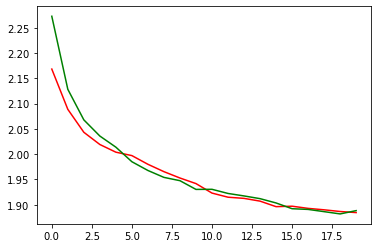

In [116]:
def callTrain(modelName = None):
    loss_fn = pt.nn.CrossEntropyLoss()	# Función de error a utilizar torch.
    if modelName == None:
        model = SurvivorClassifier() # Crea el modelo
        optimizer = pt.optim.Adam(model.parameters(), lr=1e-3)	# Optimizador
        epoch_number = 0
        best_vloss = 1_000_000.
        loss_train = []
        loss_test = []

    else:
        checkpoint = pt.load(modelName)
        model = SurvivorClassifier()
        model.load_state_dict(checkpoint["model_state_dict"])  # Crea y carga el modelo
        optimizer = pt.optim.Adam(model.parameters(), lr=1e-3)
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])	# Crea y carga el optimizador
        epoch_number = checkpoint["epoch"] # Carga las epocas donde quedo el modelo
        best_vloss = checkpoint["loss"] # Carga la menor perdida alcanzada por el modelo
        loss_train = checkpoint["loss_train"]
        loss_test = checkpoint["loss_test"]

    return completeTrain(epoch_number,best_vloss,model,optimizer,loss_fn,loss_test,loss_train)
    
EPOCHS = 5
loss_train,loss_test = callTrain("myModel")
plt.plot(loss_train,color = "r")
plt.plot(loss_test,color = "g")
plt.show()

In [ ]:
plt.plot(loss_train,color = "r")
plt.plot(loss_test,color = "g")
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
model = SurvivorClassifier()	# Crea el modelo
loss_fn = pt.nn.CrossEntropyLoss()		# Función de error a utilizar torch.
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
tensorBoard = False


EPOCHS = 2


def completeTrain(epoch_number,best_vloss):
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number,model,optimizer,loss_fn)
        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        
        voutputs = model(x_test)
        vloss = loss_fn(voutputs, y_test.long())
        running_vloss += vloss


        # for i, vdata in enumerate(test_dataloader):
        #     vinputs, vlabels = vdata
        #     voutputs = model(vinputs)
        #     vloss = loss_fn(voutputs, vlabels.long())
        #     running_vloss += vloss
        avg_vloss = running_vloss
        # avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Propotion: {}'.format(information(voutputs,y_test)))
        # # Log the running loss averaged per batch
        # # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("entra")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            pt.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_vloss,
            }, "myModel")

        epoch_number += 1
epoch_number = 0
best_vloss = 1_000_000.
completeTrain(epoch_number,best_vloss)

EPOCH 1:
LOSS train 2.3070266246795654 valid 2.3033571243286133
Propotion: 0.1016
entra
EPOCH 2:
LOSS train 2.2961673021316527 valid 2.2838504314422607
Propotion: 0.1217
entra


In [17]:
def loadModel(name):
    checkpoint = pt.load("finalModel")
    model = SurvivorClassifier()
    model.load_state_dict(checkpoint["model_state_dict"])
    model.train(False)
    return model


In [16]:
import pandas as pd
import seaborn as sns
def calculate_confusion_matrix(predict, real):
    df = pd.DataFrame(index=names,columns=names).notnull().astype('uint') # df [c][f]
    for i in range(y_test.size().numel()):
        df[names[real[i].item()]] [names[predict[i].item()]]+=1
    
    return df.astype(int)
    # P =  Predict 
    # R =  Real 
    # [1 .(P=F,R=F) = ,2. (P=F,R=T)],[3. (P=T,R=F),4. (P=T,R=T)]
    # [4] [3]
    # [2] [1]
model = loadModel("finalModel")
y_test = y_test.to(pt.int32)
voutputs = model(x_test)
predict = pt.argmax(voutputs, dim=1)
df = calculate_confusion_matrix(predict,y_test)

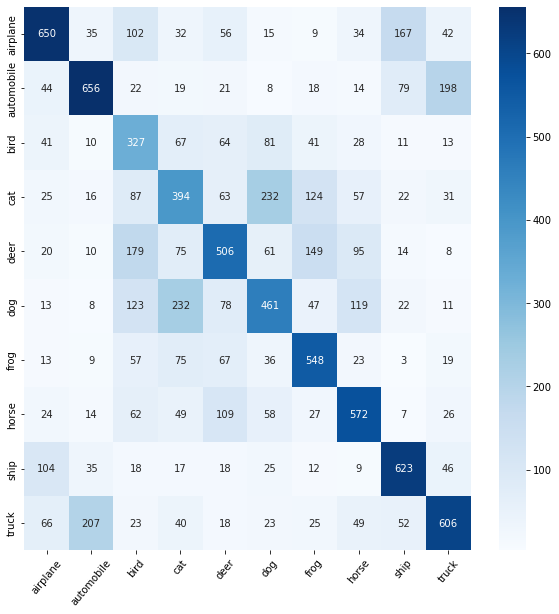

In [50]:
ax = sns.heatmap(df, annot=True,fmt='g', cmap='Blues')
sea = ax.set_xticklabels(ax.get_xticklabels(),rotation = 50)

Acurracy: 0.5343


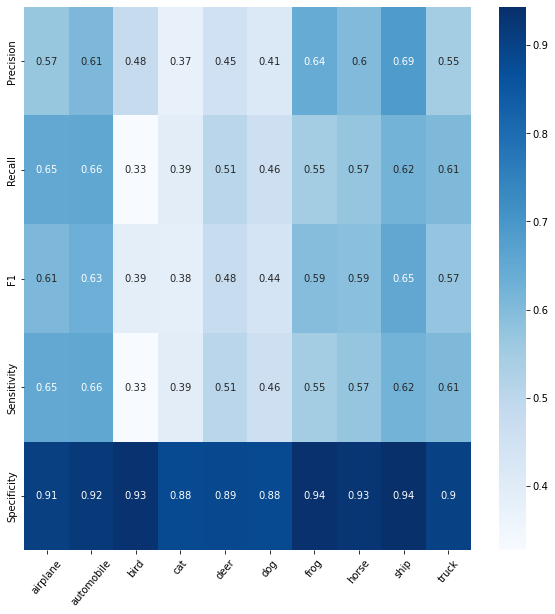

In [49]:
def getAccurracy(df):
    trues = np.diagonal(df)
    totalVal = df.values.sum() 
    return trues.sum() / totalVal


def getTP(df,Class):
    return df[Class][Class]

def getTN(df,Class):
    return np.diagonal(df).sum()-df[Class][Class]

def getFP(df,Class):
    return df[Class:Class].values.sum()-df[Class][Class]

def getFN(df,Class):
    return df[Class].values.sum()-df[Class][Class]


def getConfusionClass(df,Class,keys):
    tp = getTP(df,Class)
    tn = getTN(df,Class)
    fp = getFP(df,Class)
    fn = getFN(df,Class)
    prec = tp / (tp+fp)
    reca = tp / (tp+fn)
    return {
                keys[0]: prec,
                keys[1]:reca,
                keys[2]: 2 * prec*reca /(prec+reca),
                keys[3]: reca,
                keys[4]:tn/(tn+fp)
            }

keys = ["Precision","Recall","F1","Sensitivity","Specificity"]
statitics = {}
for i in keys:
    statitics[i] = []
for name in names:
    nameStatitics = getConfusionClass(df,name,keys)
    for key in statitics:
        statitics[key].append(nameStatitics[key])

print("Acurracy: {}".format(getAccurracy(df)))
stats = pd.DataFrame(statitics,index = names).transpose()
ax = sns.heatmap(stats, annot=True, cmap='Blues')
sea = ax.set_xticklabels(ax.get_xticklabels(),rotation = 50)

1. Se nota de forma general que el modelo confunde más las siguientes figuras, al tener estadísticas menores al 50%:
* Bird
* Cat
* Deer 
* Dog
2. Se considera que esta situación sucede principalmente, por que el modelo se adapta de mejor forma para encontrar medios de transporte, donde debe de observarse que para estas categorías se obtuvieron estadísticas mayores al 55%, donde contrario a los medios de transporte solo 2 de los 6 animales alcanza estos valores , siendo estos los sapos y los caballos.
